In [2]:
using Pkg
Pkg.activate(".")

In [1]:
using Plots

# Optimization & Root finding

1. Root finding: find $x$ such that $f(x)=0$
    - Newton-Raphson (see below)
    - more generally: gradient descend $\subset$ linesearch 
    - Bisection: gradient free
2. Optimization: find $\argmin_x f(x)$
    - Constraint or unconstraint
    - Local or global
        - local is "easy": follow the gradient
        - global is typically hard. Function may have _many_ local minima. Finding the global one may require searching parameter space exhaustively. Unless problem is convex.
    - with or without Jacobian
3. If $f$ is differentiable, then local optimization is equivalent to finding roots of $f'$.
    - gradient methods require _Hessian_ (or some approximation) of $f$.
        - Famous example: _Newton-Raphson_: $x_{k+1} = x_k - f'(x_k)/f''(x_k) $
        - Approximate Hessian: e.g. _BFGS_
        - More generally: _line search_, $x_{k+1} = x_k + \alpha_k p_k$ where $p_k$ is a descend direction and $\alpha_k$ a cleverly chosen step-width.
4. Vice-versa: Read the root finding problem as $\argmin_x \Vert f(x) \Vert^2 $. While mathematically equivalent, it is not advisable to so in practice for (at least) two reasons. By turning a system of $n$ equations into a scalar, much of the information in the Jacobian is lost.
Secondly, the condition number of the optimization problem is the square of the original.

_Literature:_
* Nocedal & Wright, _Numerical Optimization_ (2006), Springer

# Automatic Differentiation

* https://mitmath.github.io/18337/lecture10/estimation_identification
* https://juliadiff.org/ChainRulesCore.jl/dev/index.html
* https://github.com/MikeInnes/diff-zoo
* https://github.com/JuliaDiff/ForwardDiff.jl/
* https://github.com/FluxML/Zygote.jl

Two ways to evaluate derivatives on a computer.

1. Finite differencing. 
2. Using information about primitive derivatives and the chain rule, aka AD.

Consider a sequence of functions $y = y_n\circ y_{n-1} \circ\cdots \circ y_1$. By the chain rule
$$ \frac{\partial y}{\partial x} = \frac{\partial x}{\partial x}\frac{\partial y_1}{\partial x}\frac{\partial y_2}{\partial y_1}\cdots\frac{\partial y_n}{\partial y_{n-1}}\frac{\partial y}{\partial y_n}\frac{\partial y}{\partial y} $$

Two ways to read the chain rule. Left to right (_forward mode_), right to left (_reverse mode, adjoint, backpropagation,..._).

<img src="img/forward_reverse.jpg" width=600/>

* __Forward mode__
   Keep track of derivatives during the forward pass (i.e. function evaluation). Easy to realize with _dual numbers_ $a+b\epsilon$ with $\epsilon^2=0$. Then set $f(a+b\epsilon) \equiv f(a) + bf'(a)\epsilon$ and observe that the chain rule is fulfilled.  
   Propagates _perturbations_ forward. In mathematical parlance, pushforward of tangent vector $v$, i.e. $v=e_i$.  In terms of Jacobians $Jv = J_nJ_{n-1}\cdots J_1 v$  
   Disadvantage: Need $N$ passed to determine all partial derivatives for $f: \mathbb{R}^N \to \mathbb{R}^M$, __but__ get derivatives of all $M$ components simultaneously.
   
  The appropriate Julia package is `ForwardDiff.jl`.
   
   
* __Reverse mode__
   Make a forward pass and record the computational graph and intermediate values. Then traverse the graph backwards, propagating _sensitivities_ $\bar{x} \equiv \frac{\partial y}{\partial x}$ back (hence backpropagation).
   Mathematically this corresponds to pulling back the differential $dy = v_i\, dy^i$. Identify components $v_i$ with vector $v$ this yields a vector-Jacobian-product $(v^tJ_n)J_{n-1}\cdots J_1$, or transposing, $J_1^t\cdots J^t_{n-1}J^t_nv$, hence the name adjoint methods.  
   For a given output sensitivity, reverse mode AD computes partials for all inputs, __but__ needs $M$ passes to calculate all columns of the Jacobian.


Two main packages implement reverse-mode AD currently: `ReverseDiff.jl` and `Zygote.jl`. While the former is tape-based (as described above), Zygote does source-to-source transformation, i.e. it hooks into the compiler. This allows to differentiate through control flow, like if-statements and for-loops.

See https://juliadiff.org/






## Example:

In [4]:
import ForwardDiff, DiffRules, Zygote

In [ ]:
G(x) = x[1]^2 + x[2]^2

In [12]:
G(x,y) = x^2 + y^2

G (generic function with 1 method)

In [ ]:
ForwardDiff.gradient(G, [1.0, 2.0])

In [ ]:
d = ForwardDiff.Dual{typeof(G), Float64, 1}(2.0, ForwardDiff.Partials{1, Float64}((1.0,)))

In [ ]:
G(1.0, d)

This works, because `ForwardDiff` overloads many functions with methods that accept and propagate dual numbers.

In [ ]:
methods(sin)

In [ ]:
DiffRules.diffrule(:Base, :sin, :x)

The same in reverse:

In [9]:
dG = (x,y)->Zygote.gradient(G, x,y)

#7 (generic function with 1 method)

In [17]:
dG(1.0, 2.0)

(2.0, 4.0)

# Root finding

## `Roots.jl`: derivative (free) and bisection methods for scalar, univariate functions

In [1046]:
import Roots

In [1047]:
f(x) = exp(-x^2) - x

f (generic function with 2 methods)

In [1048]:
Roots.find_zero(f, 5.0)

0.6529186404192048

In [1049]:
Roots.find_zeros(sin, -4π, 4π) ./ π

9-element Vector{Float64}:
 -4.0
 -3.0
 -2.0
 -1.0
  0.0
  1.0
  2.0
  3.0
  4.0

## `NLsolve`: (Quasi-)Newton and Trust-Region algorithm. Supports `LineSearches.jl`

### Example 1: One input, one output

In [748]:
@. V(x) = 1/4*x^4 - x^2 + x/6 + 1.2

V (generic function with 1 method)

In [756]:
Vopt = nlsolve(V, [2.0], ftol=1e-8, iterations=10_000, method=:trust_region)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [2.0]
 * Zero: [1.3705451042286423]
 * Inf-norm of residuals: 0.432121
 * Iterations: 10000
 * Convergence: false
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: false
 * Function Calls (f): 73
 * Jacobian Calls (df/dx): 19

Algorithm freezes when the gradient becomes zero.

In [764]:
jacobian(V, Vopt.zero)

([-2.008702093547754e-9],)

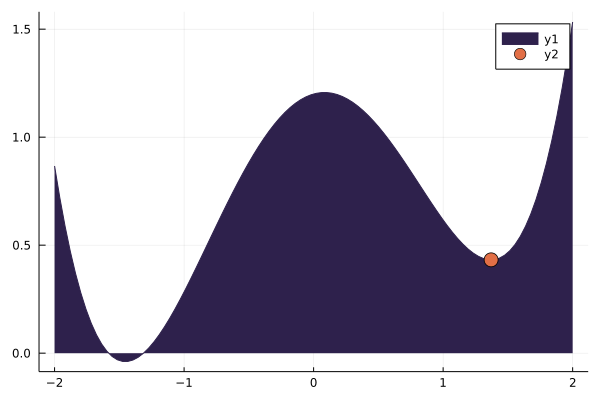

In [762]:
_x = _y = range(-2,2,length=100)
plot(_x, x->V(x), fill=true, c=:acton)
scatter!(Vopt.zero, V(Vopt.zero), ms=8)

In such cases it might help to change the algorithm (here from the default trust region to plain Newton), or change the starting position.

In [766]:
Vopt = nlsolve(V, [2.0], method=:newton)

Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [2.0]
 * Zero: [-1.3134067454748466]
 * Inf-norm of residuals: 0.000000
 * Iterations: 13
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 14
 * Jacobian Calls (df/dx): 14

### Example 2: One output, multiple inputs

In [3]:
import NLsolve

__!!Big Warning!!:__ Whether it is a bug or a "feature" is unknown, but `NLsolve` requires the __output dimension to be equal to the input dimension__. Anything else may lead to strange behavior.

In [462]:
# pad the output with an appropriate number of zeroes
F1(x) = [sin(x[1])*sin(x[2])/sqrt(1+x[1]^2+x[2]^2); zeros(eltype(x), length(x)-1)]

F1 (generic function with 2 methods)

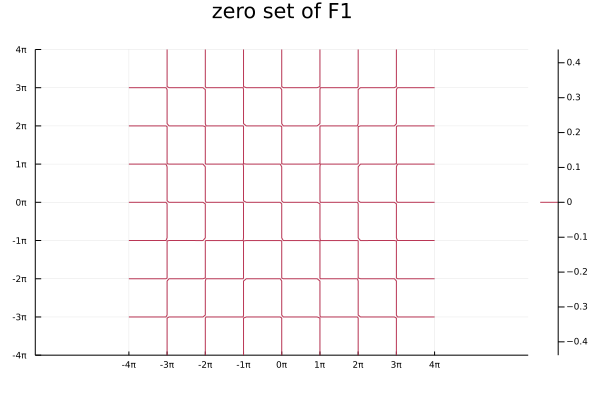

In [636]:
_x = _y = range(-4π,4π,length=100)
contour(_x,_y,(x,y)->F1([x,y])[1],
    fill=false, ratio=1,
    xticks=(-4π:π:4π, ["$(k)π" for k in -4:4]),
    yticks=(-4π:π:4π, ["$(k)π" for k in -4:4]),
    tickfontsize=6,
    levels=[0],
    title="zero set of F1")

The algorithm stops if the residual has reached `ftol` (default 1e-8, here we set it lower), or 
max. number of iterations (default 1000) is reached.
Set `autodiff=:forward` to compute gradient through AD. Otherwise finite differencing is used when
no gradient is provided.  

The function has degenerate minima. Each run of the solver produces a different one, depending
on initial conditions.

In [503]:
F1opt = NLsolve.nlsolve(F1, (4π*rand(2).-2π),
    ftol=1e-12, autodiff=:forward)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [-2.172208612699194, 3.557879201975485]
 * Zero: [-2.335572813168494, 3.1415926535884235]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-12: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [507]:
F1opt.zero ./ π

2-element Vector{Float64}:
 -0.743435916333619
  0.999999999999564

### Example 3

In [546]:
import LinearAlgebra: svd, eigen

In [548]:
import LinearAlgebra

In [557]:
F2(x, Q) = [1 - exp(-x'*Q*x/2); zeros(length(x)-1) ]

F2 (generic function with 2 methods)

In [556]:
# inv covariance matrix
Q = randn(10,10)
Q = inv((Q'+Q)/2);
# make positive definite
E = eigen(Q)
Q = E.vectors * LinearAlgebra.diagm(abs.(E.values)) * E.vectors'

10×10 Matrix{Float64}:
  3.40183     1.09686    -0.235275  …  -1.36124     0.0678449  -1.31304
  1.09686     1.37396     0.422769     -0.901699   -0.0306078  -1.06368
 -0.235275    0.422769    1.32163      -0.188363   -0.512135   -0.438237
  0.0223999  -0.139375    0.260583      0.226163   -0.305384    0.325913
  0.855318    0.330469   -0.130896     -0.368065    0.0732537  -0.366669
  0.476691    0.444859    0.409825  …  -0.390143   -0.260045   -0.438353
 -0.518208   -0.149121   -0.215         0.215108    0.21883    -0.0029109
 -1.36124    -0.901699   -0.188363      1.38457     0.0652092   1.04146
  0.0678449  -0.0306078  -0.512135      0.0652092   0.640086    0.0511566
 -1.31304    -1.06368    -0.438237      1.04146     0.0511566   1.57779

In [603]:
# record trace to see how fnorm decreases.
# recording an extended trace (all values of x and f,df) can become expensive
@time Fopt = NLsolve.nlsolve(x->F2(x,@view Q[1:2,1:2]), rand(2), method=:trust_region,
   autoscale=false, xtol=1e-14, ftol=0*1e-14, autodiff=:forward, store_trace=true, extended_trace=true)

  1.440871 seconds (3.75 M allocations: 207.443 MiB, 10.65% gc time, 95.13% compilation time)


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg
 * Starting Point: [0.9693549633662208, 0.12399277483192028]
 * Zero: [3.016543020567872e-9, -9.81769208213004e-9]
 * Inf-norm of residuals: 0.000000
 * Iterations: 37
 * Convergence: true
   * |x - x'| < 1.0e-14: false
   * |f(x)| < 0.0e+00: true
 * Function Calls (f): 38
 * Jacobian Calls (df/dx): 38

In [637]:
# unforunately there are no convenience functions to extract the variables from the trace (yet)
xres = map(Fopt.trace.states) do s
    s.metadata["x"]
end;

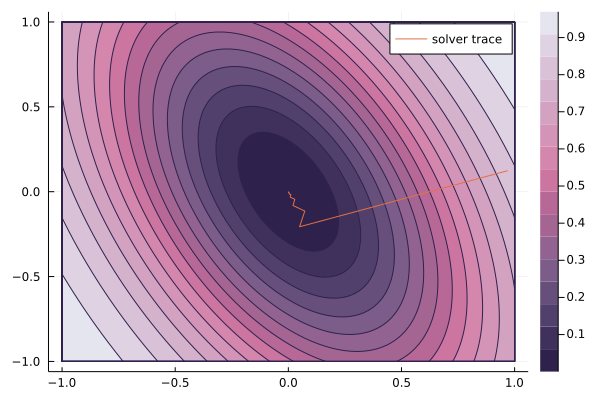

In [611]:
_x2 = _y2 = range(-1,1,length=100)
contour(_x2,_y2, (x,y)->F2([x,y], @view Q[1:2,1:2])[1],fill=true, c=:acton)
plot!(Tuple.(xres), lab="solver trace")

Residual function norm decreases exponentially.

In [614]:
using LaTeXStrings

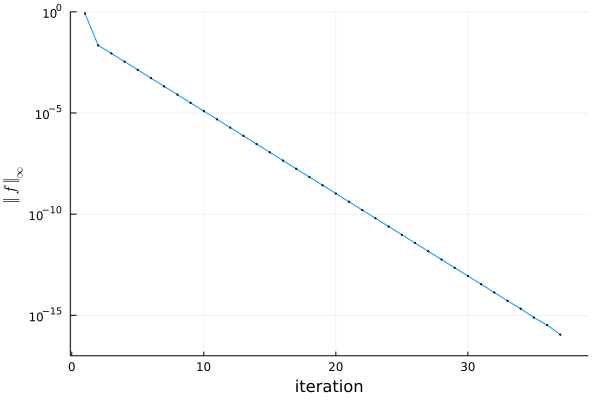

In [629]:
plot( getfield.(Fopt.trace.states, :fnorm),
    yscale=:log10, ylim=(1e-17,1),
    marker=(:circ, 1),
    lab="", xlabel="iteration", ylabel=L"\Vert f\; \Vert_\infty" )

# Optimization

## Least square methods

Common task: Given data $(x,y)$, find parameters such that $\Vert f(x;p) - y \Vert^2_2$ is minimal.

Often $f(x;p) = Xp$ is a linear problem. If noise is Gaussian, then least-squares is max-likelihood.

### `GLM` - (Generalized) Linear Models

Linear, logistic, probit, ... regression

In [770]:
using DataFrames, GLM

In [771]:
n = 20

20

In [772]:
data = DataFrame(x1=range(0,2π,length=n), x2=range(-π,π,length=n))

data.y = data.x1*1 + data.x2*2 + 0.2*randn(length(data.x1));

In [773]:
data

20×3 DataFrame
 Row │ x1        x2         y         
     │ Float64   Float64    Float64   
─────┼────────────────────────────────
   1 │ 0.0       -3.14159   -6.32551
   2 │ 0.330694  -2.8109    -5.31055
   3 │ 0.661388  -2.4802    -3.94745
   4 │ 0.992082  -2.14951   -3.6308
   5 │ 1.32278   -1.81882   -2.21897
   6 │ 1.65347   -1.48812   -1.4294
   7 │ 1.98416   -1.15743   -0.463922
   8 │ 2.31486   -0.826735   0.652452
   9 │ 2.64555   -0.496041   1.48494
  10 │ 2.97625   -0.165347   2.64684
  11 │ 3.30694    0.165347   3.67872
  12 │ 3.63763    0.496041   4.56385
  13 │ 3.96833    0.826735   5.73489
  14 │ 4.29902    1.15743    6.82992
  15 │ 4.62972    1.48812    7.58921
  16 │ 4.96041    1.81882    8.60289
  17 │ 5.2911     2.14951    9.54785
  18 │ 5.6218     2.4802    10.5882
  19 │ 5.95249    2.8109    11.499
  20 │ 6.28319    3.14159   12.2672

In [774]:
x = Array(data[:,1:2]);

In [775]:
lm(@formula(y ~ x1+x2+1), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x1 + x2

Coefficients:
───────────────────────────────────────────────────────────────────────────
                Coef.   Std. Error       t  Pr(>|t|)   Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  0.0       NaN          NaN       NaN     NaN         NaN
x1           0.992479    0.0111617   88.92    <1e-24    0.969029    1.01593
x2           1.9981      0.0215115   92.89    <1e-24    1.95291     2.04329
───────────────────────────────────────────────────────────────────────────

### `LsqFit` - Levenberg-Marquardt

Variant of Gauss-Newton with regularisation. Requires gradient.

In [776]:
using LsqFit

In [783]:
data.z = sin.(data.x1*1 + data.x2*2) .+ 0.1*randn(length(data.x1));

Minimize $ \sum_i (f_i(x;p)i - z_i)^2 $

Trial functions $f(x;p) \sim \sin(x\cdot p_1) + \cos(x\cdot p_2) + 1$

In [778]:
x

20×2 Matrix{Float64}:
 0.0       -3.14159
 0.330694  -2.8109
 0.661388  -2.4802
 0.992082  -2.14951
 1.32278   -1.81882
 1.65347   -1.48812
 1.98416   -1.15743
 2.31486   -0.826735
 2.64555   -0.496041
 2.97625   -0.165347
 3.30694    0.165347
 3.63763    0.496041
 3.96833    0.826735
 4.29902    1.15743
 4.62972    1.48812
 4.96041    1.81882
 5.2911     2.14951
 5.6218     2.4802
 5.95249    2.8109
 6.28319    3.14159

In [779]:
f(x, p) = p[1].*sin.(p[2].*x[:,1] + p[3]*x[:,2]) .+  p[4] .*cos.(p[5].*x[:,1] + p[6]*x[:,2]) .+ p[7]

f (generic function with 1 method)

In [1063]:
f(x, ones(7))

20-element Vector{Float64}:
 -2.220446049250313e-16
 -0.4033532220860614
 -0.21488575308012936
  0.4859220979979124
  1.4035263581694155
  2.1509558936834563
  2.413005482298873
  2.0791638384790025
  1.2902183201401018
  0.378882227504049
 -0.27051671090531815
 -0.38411463638495547
  0.08599485246566252
  0.9415576609526084
  1.8217667131219877
  2.3554211442435626
  2.317468751308027
  1.723914778798532
  0.8250722032932748
  3.3306690738754696e-16

In [784]:
ffit = LsqFit.curve_fit(f, x, data.z, rand(7))

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}}([0.06981070508636451, 0.5754994105399089, 1.4578734147987844, 1.0075451946640968, -44.50359834412864, -110.50236431486421, 0.003137830030906994], [0.10373841149476717, -0.12310642456879284, -0.02526980989461991, 0.11700091257600378, -0.08593326770715692, -0.050998607642469884, -0.05922938872921485, 0.06878314857572554, -0.028674215338743148, -0.13150528552216512, 0.013616761660827759, 0.09509675467227985, -0.005469857860488814, -0.1061553189634592, 0.10698434704906012, 0.04093679264438854, 0.06357999311268195, -0.08022756390323749, 0.04839814043575574, 0.038434477907429786], [0.9912552322837487 0.0 … 3.1652069346491425 0.9999999999983442; 0.6932779521371444 -0.016637379234565618 … 1.5619275619201498 0.9999999999960525; … ; 0.9459152775964178 0.1348093650563987 … -1.6149367743551368 0.9999999999960525; 0.9420750013093667 -0.14711870993044154 … -3.163866480897751 1.000000000000636], true, Float64[])

In [791]:
println("L2 residue: ", sum(abs2, ffit.resid))

L2 residue: 0.12453272203419474


In [792]:
ffit.param

7-element Vector{Float64}:
    0.06981070508636451
    0.5754994105399089
    1.4578734147987844
    1.0075451946640968
  -44.50359834412864
 -110.50236431486421
    0.003137830030906994

In the presence of noise, the model is confused. Least-squares cannot reliably discriminate the sine and cosine terms. Dropping the latter yields an acceptable fit.

### `Optim.jl`

Written in pure Julia. Supports many (well-known) gradient based (Newton, Trust-Region, Conjugate Gradient,...) and non-gradient (Nelder-Mead, Simulated Annealing,...).

Gradient-based algorithms utilize `LineSearches.jl`.

Some support for bounded problems.

In [73]:
using Optim

In [790]:
optim_res = Optim.optimize(p->sum(abs, f(x, p).-data.z), rand(7), NelderMead(), autodiff=:forward)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.146344e+01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1633


In [789]:
[optim_res.minimizer ffit.param]

7×2 Matrix{Float64}:
  0.0138492     0.0698107
  1.12602       0.575499
  0.46808       1.45787
  1.02607       1.00755
 -2.50096     -44.5036
 -0.511951   -110.502
  0.0134117     0.00313783

In [359]:
Optim.optimize(x->F1(x)^2, 4π*rand(2).-2π, NewtonTrustRegion(), autodiff=:forward)

 * Status: success

 * Candidate solution
    Final objective value:     4.500670e-16

 * Found with
    Algorithm:     Newton's Method (Trust Region)

 * Convergence measures
    |x - x'|               = 5.96e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.34e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.95e-16 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.54e+00 ≰ 0.0e+00
    |g(x)|                 = 8.98e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    25
    f(x) calls:    26
    ∇f(x) calls:   26
    ∇²f(x) calls:  13


In [793]:
Optim.optimize(x->(1-exp(-sum(abs2, x)))^2, rand(2), ConjugateGradient(), autodiff=:forward,
    Optim.Options(g_tol=1e-14))

 * Status: success

 * Candidate solution
    Final objective value:     3.104638e-20

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 6.18e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.15e-01 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.33e-19 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.27e+00 ≰ 0.0e+00
    |g(x)|                 = 8.45e-15 ≤ 1.0e-14

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    19
    f(x) calls:    39
    ∇f(x) calls:   20


In [794]:
ans.minimizer / π

2-element Vector{Float64}:
 -3.8169363344989334e-6
 -1.8121182300550205e-6

### `NLopt`

The heavy hitter. The package is a wrapper for the open-source, large-scale optimization library `NLopt`. See the [documentation](https://nlopt.readthedocs.io/en/latest/NLopt_Introduction/).

Can be used very comfortably as a solver backend for JuMP.

### `JuMP`

Modeling language for optimization problems similar to [AMPL](https://ampl.com/).
Supports many different solvers with a unifying syntax.

In [1080]:
using JuMP, Ipopt

Initialize a "model" and specify the optimizer. Can be changed later.

#### Least-squares again

In [1081]:
jump_model = Model(Ipopt.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt

Declare optimization variables.

In [1082]:
@variable(jump_model, p[1:7], start=1.0)

7-element Vector{VariableRef}:
 p[1]
 p[2]
 p[3]
 p[4]
 p[5]
 p[6]
 p[7]

For convenience we define shorthands for the deviation of the model from the data. Importantly, we these expressions are nonlinear, hence we need to use the `@NLexpression` instead of `@expression` macro to declare them.

In [1085]:
delta = @NLexpression(jump_model, delta[i=1:n], (p[1]*sin(x[i,1]*p[2]+x[i,2]*p[3]) + p[4]*cos(x[i,1]*p[5]+x[i,2]*p[6]) + p[7]) - data.z[i]);

We are trying to minimize a nonlinear objective.

In [1088]:
@NLobjective(jump_model, Min, sum(delta[i]^2 for i=1:n))

Setting the cosine term in the model to zero will yield a nice fit.

In [1093]:
@constraint(jump_model, p[4]==0)

p[4] == 0.0

In [1089]:
print(jump_model)

In [1094]:
JuMP.optimize!(jump_model)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       28

Total number of variables............................:        7
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [1095]:

[value.(p) ffit.param]

7×2 Matrix{Float64}:
  0.991843      0.991843
  0.999095      0.999095
  2.00399       2.00399
 -1.14794e-41   1.0
  1.00036       1.0
  1.00039       1.0
 -0.00848671   -0.00848671

#### Ising

The least-squares problem was trivial, but that is not what JuMP was made for. Through its plethora of supported backends, it can solve not only (nonlinear) programs over the real numbers, but is capable of (mixed)-integer (non)linear programming.

The [documentation](https://jump.dev/JuMP.jl/stable/) has many interesting examples. They are worth a look.

Here we try to ind groundstate of a random coupling Ising model using M(ixed)I(nteger)N(on)L(inear)P(rogramming) (_MINLP_), and verify it by brute force.

`Juniper` is a pure Julia solver for MINLPS. It requires a nonlinear solver like Ipopt or NLopt in addition.

In [1096]:
using Juniper

In [1107]:
optimizer = Juniper.Optimizer
nl_solver = optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>0)

ising = Model(optimizer_with_attributes(optimizer, "nl_solver"=>nl_solver))

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Juniper

In [8]:
# no. of spins
N = 16

16

In [9]:
@variable(ising, s[1:N], Bin); # binary variables

LoadError: LoadError: UndefVarError: @variable not defined
in expression starting at In[9]:1

In [10]:
# create a NxN symmetric matrix of couplings. 
J = randn(N,N);
J[ abs.(J) .< 2*0.67 ] .= 0; # Make it sparse.
J = (J + J')/2

16×16 Matrix{Float64}:
  1.97845    0.0        0.0       …   0.0        0.0       -1.14977
  0.0        0.0        0.789078      0.0       -0.855442   0.0
  0.0        0.789078   0.0          -0.832977   0.0        0.0
  0.0        0.791762   0.0           0.0        0.0        0.0
  0.0       -0.692113  -0.696907      0.0       -0.756122   0.0
 -0.855328   0.0        0.0       …  -0.872484   0.0        0.0
  0.910379  -0.892005   0.0           0.0        0.0       -0.898417
  0.756153   0.0        0.0           0.0        0.0        0.0
 -0.711822   0.0        0.0           0.0        0.0        0.0
 -1.07542    0.0        0.0           0.0        0.0        0.0
  0.932559   0.0       -1.08682   …   0.0        0.0        0.0
  0.0        0.0        0.0          -0.70753    0.0        0.0
  0.0       -0.902877  -1.16485       1.1358     0.0        0.0
  0.0        0.0       -0.832977      0.0        0.696587   0.0
  0.0       -0.855442   0.0           0.696587   0.0        0.0
 -1.1497

In [11]:
# sparsity
count(x->x==0, J)/N^2

0.70703125

In [1110]:
# Hamiltonian is the objective function.
@NLobjective(ising, Min, 
    sum( -J[i,j]*(2*s[i]-1)*(2*s[j]-1) for i=1:N, j=1:N)
);

In [1111]:
JuMP.optimize!(ising)

nl_solver         : MathOptInterface.OptimizerWithAttributes(Ipopt.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawParameter("print_level") => 0])
feasibility_pump  : false
log_levels        : [:Options, :Table, :Info]

#Variables: 16
#IntBinVar: 16
Obj Sense: Min

Incumbent using start values: 4.573174156176339
Status of relaxation: LOCALLY_SOLVED
Time for relaxation: 0.03900003433227539
Relaxation Obj: -36.7104009457249

 ONodes   CLevel          Incumbent                   BestBound            Gap    Time   Restarts  GainGap  
    0       2               -37.24                      -36.71            1.41%   0.0       0         -     

#branches: 1
Obj: -37.237039461158474


In [1103]:
value.(s)

16-element Vector{Float64}:
 1.0
 0.0
 0.0
 1.0
 0.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0

Compare this with the/an exact ground-state.

In [ ]:
# Convert an integer into a vector of its binary
# representation, padded to a minimal length.
# Used to iterate over all spin configurations.
function int2bin(x::Int; pad::Int=0)
    if x==0
        return zeros(Int, max(1, pad))
    end
    exponent = floor(Int, log2(x))+1
    m = max(exponent, pad)
    b = zeros(Int, m)
    for i=1+(m-exponent):exponent+(m-exponent)
        e = exponent-i+(m-exponent)
        b[i] = x÷(2^e)
        x -= b[i]*2^e
    end
    b
end

In [1112]:
## Brute force through all configurations. 

H(s) = sum( -J[i,j]*(2*s[i]-1)*(2*s[j]-1) for i=1:N, j=1:N)

best = zeros(N)
bestH = H(best)
for i = 0:2^N-1
    local s = int2bin(i, pad=N)
    newH = H(s)
    if newH < bestH
        bestH = newH
        best = s
    end
end

In [1113]:
H(value.(s)), bestH

(-37.23703795077842, -37.23703795077842)

In [1114]:
[best value.(s)]

16×2 Matrix{Float64}:
 0.0  0.0
 1.0  1.0
 1.0  1.0
 0.0  0.0
 0.0  0.0
 1.0  1.0
 0.0  0.0
 1.0  1.0
 0.0  0.0
 1.0  1.0
 0.0  0.0
 0.0  0.0
 1.0  1.0
 1.0  1.0
 0.0  0.0
 0.0  0.0

# SciML

Grown out of `DifferentialEquations.jl`, SciML bundles tools for

* numerically integration of differential equations (ODE, SDE, PDE, DDE, ...) `DifferentialEquations.jl`
* sensitivity analysis `DiffEqSensitivity` (how does the solution of a DE depend on parameters/conditions?)
* parameter optimization and "Neural DE" `DiffEqFlux`, `GalacticOptim`
* modeling reaction networks `Catalyst`
* general purpose modeling language `ModelingToolkit`
* (...)

under one roof.

## An ODE

In [12]:
using OrdinaryDiffEq

┌ Info: Precompiling OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1317


$$ \dot{u} = f(u,t) $$

In [14]:
V(x,p) = p[1]*x^4 + p[2]*x^2

V (generic function with 1 method)

In [15]:
function anharm!(du, u, param, t)
    x,p = u
    m,a,b = param # V(x) = ax^4 + bx^2
    du[1] = p/m
    du[2] = -(4a*x^3 + 2b*x)
end

anharm! (generic function with 1 method)

In [20]:
x0 = 0.9
p0 = 0.0

0.0

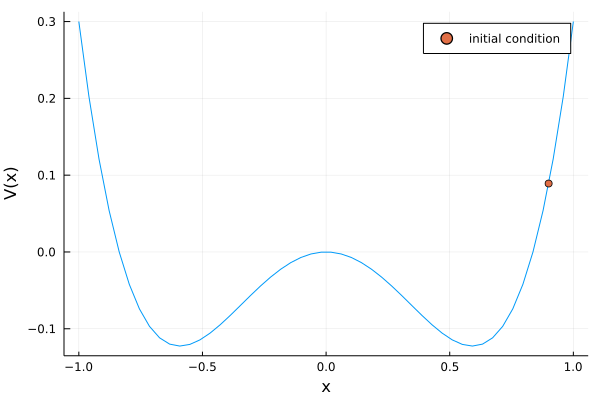

In [345]:
xs = range(-1,1,length=50)
plot(xs, x->V(x, [1,-0.7]), lab="", ylabel="V(x)", xlabel="x")
scatter!([x0], x->V(x, [1,-0.7]), lab="initial condition")

In [21]:
anharm_prob = ODEProblem(anharm!, [x0, p0], (0.0,10.0))

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 0.9
 0.0

In [22]:
?Tsit5

search: Tsit5 AutoTsit5 TsitPap8 AutoSwitch startswith methodswith



@article{tsitouras2011runge,   title={Runge–Kutta pairs of order 5 (4) satisfying only the first column simplifying assumption},   author={Tsitouras, Ch},   journal={Computers \& Mathematics with Applications},   volume={62},   number={2},   pages={770–775},   year={2011},   publisher={Elsevier} }

Tsit5: Explicit Runge-Kutta Method    Tsitouras 5/4 Runge-Kutta method. (free 4th order interpolant).


In [346]:
anharm_sol = OrdinaryDiffEq.solve(anharm_prob, Tsit5(); p=[1.0,1.0,-0.7])

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 32-element Vector{Float64}:
  0.0
  0.0006031945181682187
  0.006635139699850405
  0.03747626414348308
  0.1009742780913045
  0.19131063508159712
  0.30639302129973167
  0.4501997715112692
  0.6229080103211376
  0.8298982977059854
  1.080150831136878
  1.3955555539963906
  1.7992418764696905
  ⋮
  5.179838384533015
  5.705835610149488
  6.262537304270996
  6.736107582506136
  7.213455311840753
  7.608303397442797
  8.015226158808574
  8.39369543433515
  8.859758649942341
  9.405075377591007
  9.96294580726859
 10.0
u: 32-element Vector{Vector{Float64}}:
 [0.9, 0.0]
 [0.899999698737553, -0.0009988896181169003]
 [0.8999635483473746, -0.01098712059039329]
 [0.8988382297948632, -0.06194000807788325]
 [0.8916171240201188, -0.1648746421136515]
 [0.8704449908460626, -0.30133540618409804]
 [0.8270141596874052, -0.44738298837378804]
 [0.7528032614470189, -0.5738213755029141]
 [0.6465020411979303, -0.6433975551646387]


In [347]:
anharm_sol(0.5)

2-element Vector{Float64}:
  0.7234809110571407
 -0.6025328080529119

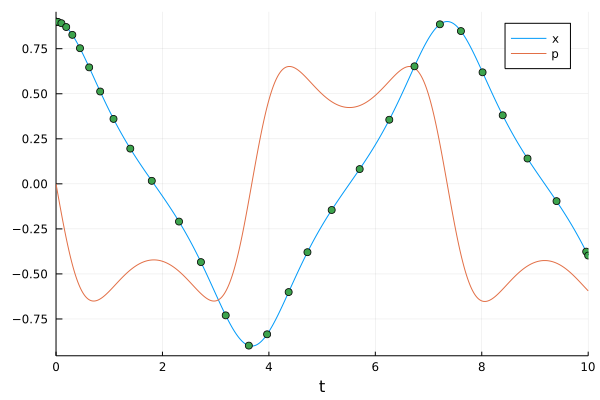

In [348]:
plot(anharm_sol, lab=["x" "p"])
anharm_plot = scatter!(anharm_sol.t, getindex.(anharm_sol.u, 1), lab="")
#vline!([find_period(pdefault)], lab="")

To find the period of oscillation, we integrate the system until the momentum reverses, i.e. $p(t_f) = 0$.

We use a `ContinuousCallback(cond, affect!)`. It applies when `cond==0` and is triggered when `cond` crosses from neg. to pos. or vice versa.
__Then it tracks back to the exact time point where the condition hit zero.__

`affect!` is a function to modify the integrator. Here it terminates integration. Other uses include affecting the current state, e.g. imparting momentum.

In [349]:
function has_reversed(u, param, integrator)
    u[2]
end

function affect!(integrator)
    terminate!(integrator)
end

cb = ContinuousCallback(has_reversed, affect!)

ContinuousCallback{typeof(has_reversed), typeof(affect!), typeof(affect!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT), Float64, Int64, Nothing, Int64}(has_reversed, affect!, affect!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, nothing, DiffEqBase.LeftRootFind, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0)

In [350]:
OrdinaryDiffEq.solve(anharm_prob, Tsit5(); tspan=(0.0,1000.0), p, callback=cb)

retcode: Terminated
Interpolation: specialized 4th order "free" interpolation
t: 13-element Vector{Float64}:
 0.0
 0.005549389484455265
 0.06104328432900791
 0.2908662316164273
 0.7245291440634899
 1.3186253286072875
 2.081322175316053
 3.0174392373939067
 4.070084426556369
 5.108416682145022
 6.440049400816498
 7.024789249567006
 7.024789249567006
u: 13-element Vector{Vector{Float64}}:
 [0.9, 0.0]
 [0.8999972283862527, -0.0009988890967020656]
 [0.8996646553916988, -0.010986426606611557]
 [0.8923964455069153, -0.05220839811924832]
 [0.8531670767292859, -0.12814518112318105]
 [0.7479931804890754, -0.2238330563563269]
 [0.537476304026311, -0.32283715922128225]
 [0.1975972745598985, -0.39267166159066574]
 [-0.22214253784283072, -0.3900391063652536]
 [-0.5892124091823097, -0.30424612522895855]
 [-0.8694022001459394, -0.10405887307951463]
 [-0.9000203712827042, -1.5027474876237645e-16]
 [-0.9000203712827042, -1.5027474876237645e-16]

In [34]:
function find_period(p)
    anharm_sol = OrdinaryDiffEq.solve(anharm_prob, Tsit5(); tspan=(0.0,1000.0), p, callback=cb)
    return 2*anharm_sol.t[end]
end

find_period (generic function with 1 method)

In [32]:
pdefault = [1.0, 1.0, -0.7]

3-element Vector{Float64}:
  1.0
  1.0
 -0.7

In [351]:
find_period(pdefault)

7.35600250814389

__Goal:__ Tune parameters to have $T=10$

$ \mathrm{solve} \to \mathrm{find\_period} \to \mathrm{loss} $

Need gradient $\partial_p \mathrm{floss}$. Ultimately requires the gradient of the solution wrt. the parameters. This is known as _sensitivity analysis_ and requires the solution of a complementary _adjoint problem_. See (https://cs.stanford.edu/~ambrad/adjoint_tutorial.pdf) for example. 

The appendix of (https://arxiv.org/pdf/2001.04385.pdf) contains an overview of the different sensitivity algorithms implemented by DifferentialEquations.jl

<hr/>

<hr/>

### Learn parameters

Define an objective function that measures the deviation from the current state to the target value.

In [44]:
# AD backend, uses reverse-mode by default
using Zygote
import Zygote: forwarddiff

In [352]:
pdefault

3-element Vector{Float64}:
  1.0
  1.0
 -0.7

In [353]:
# Fix mass==1, only tune potential
# We tell Zygote to use forward-mode via ForwardDiff here
floss(p) = forwarddiff(p) do p
    (find_period([ [1.0]; p]) - 10.0)^2
end

floss (generic function with 1 method)

In [354]:
floss(pdefault[2:end])

6.990722736941402

In [355]:
Zygote.gradient(floss, pdefault[2:end])

([74.96966516780172, 79.34144965379322],)

#### Sensitivity Analysis

`DiffEqSensitivities.jl` allows recording and extracting the sensitivies (derivatives of the solution wrt. the parameters) along the solution trajectory.

In [45]:
using DiffEqSensitivity

The special `LocalSensitivityProblem` augments the original ODE with two components with 2x3 (components x parameters) components which store the corresponding sensitivities.

In [48]:
sense_prob = ODELocalSensitivityProblem(anharm!, [x0, p0], (0.0, 10.0), pdefault)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 8-element Vector{Float64}:
 0.9
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

It can then be solves as usual...

In [49]:
sense_sol = OrdinaryDiffEq.solve(sense_prob, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 38-element Vector{Float64}:
  0.0
  0.0002624536350450749
  0.002886989985495824
  0.019778102338878032
  0.049520407522312127
  0.08590308557573118
  0.13452643691929933
  0.19696905131578357
  0.2772875942943652
  0.3779811745281394
  0.5030653587960644
  0.6577726898205329
  0.8510772331463083
  ⋮
  5.848096646889143
  6.207463135697273
  6.647140716570649
  7.062272243918717
  7.420613397132744
  7.809210844521894
  8.142973010054776
  8.485255306995262
  8.828058805296761
  9.248154531815072
  9.640692650180808
 10.0
u: 38-element Vector{Vector{Float64}}:
 [0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.8999999429657808, -0.0004346231781210666, 5.70342164863585e-8, -4.1513573728200156e-11, -1.004298176010019e-7, -0.000765314678192414, -6.1993715878061e-8, -0.0004724164879784582]
 [0.8999930988990256, -0.004780800161894938, 6.9010610950302356e-6, -5.525359757812462e-8, -1.2151892082537177e-5, -0.008418300951

...and split into the actual solution and sensitivities

In [50]:
xs,dp = extract_local_sensitivities(sense_sol)

([0.9 0.8999999429657808 … -0.19995534581717897 -0.39164201496187284; 0.0 -0.0004346231781210666 … -0.4817942857996584 -0.5890948708923471], [[0.0 5.70342164863585e-8 … 2.3561330059554995 2.9910065595523534; 0.0 -4.1513573728200156e-11 … 0.9835853812901647 1.2790742202626468], [0.0 -1.004298176010019e-7 … -9.373683961260499 -11.96251655839841; 0.0 -0.000765314678192414 … -6.22234313989824 -7.3610521302727925], [0.0 -6.1993715878061e-8 … -10.025072793292399 -12.816442855493714; 0.0 -0.0004724164879784582 … -6.795662104011539 -7.846975770167734]])

In [51]:
xs'

38×2 adjoint(::Matrix{Float64}) with eltype Float64:
  0.9         0.0
  0.9        -0.000434623
  0.899993   -0.0047808
  0.899676   -0.0327348
  0.897973   -0.0817277
  0.893921   -0.140811
  0.885201   -0.217291
  0.868717   -0.30933
  0.839555   -0.413955
  0.792345   -0.5185
  0.721631   -0.604059
  0.623979   -0.648153
  0.499059   -0.634682
  ⋮          
  0.144143    0.454769
  0.323371    0.550561
  0.592429    0.650846
  0.833875    0.430469
  0.896564   -0.11062
  0.749719   -0.578378
  0.538265   -0.645833
  0.330881   -0.555562
  0.157707   -0.461444
 -0.0248368  -0.424513
 -0.199955   -0.481794
 -0.391642   -0.589095

I.e. these are the sensitivities along the solution wrt. to the second parameter

In [57]:
dp[2]'

38×2 adjoint(::Matrix{Float64}) with eltype Float64:
   0.0            0.0
  -1.0043e-7     -0.000765315
  -1.21519e-5    -0.0084183
  -0.000570074   -0.0576209
  -0.00356532    -0.143588
  -0.0106682     -0.246279
  -0.0258455     -0.376361
  -0.0541344     -0.525963
  -0.102913      -0.681042
  -0.178533      -0.80839
  -0.28447       -0.86933
  -0.417858      -0.841691
  -0.572152      -0.754358
   ⋮            
   5.40211        3.71946
   7.07245        5.26885
   8.83785        0.80286
   6.04899      -15.7179
  -1.57348      -23.4486
  -8.50118       -9.96595
  -9.75554        1.04671
  -8.72448        3.80518
  -7.66624        1.94546
  -7.69167       -2.21943
  -9.37368       -6.22234
 -11.9625        -7.36105

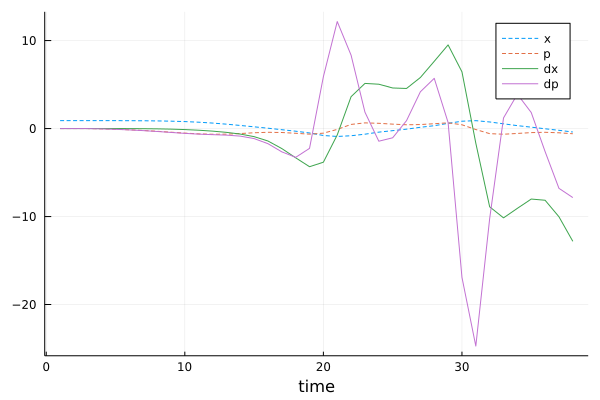

In [62]:
plot(xs', xlabel="time", ls=:dash, lab=["x" "p"])
plot!(dp[3]', lab=["dx" "dp"])

__Back to fitting the parameters of the anharmonic potential__

We can use Optim to find appropriate parameters by minimizing the loss function.
Since we would like the potential to be bounded from below and to retain the bump in the middle, we constrain the
parameters appropriately.

In [81]:
lower = [0.0, -Inf]
upper = [Inf, 0.0]
optim_popt = Optim.optimize(floss, lower, upper, pinit, Optim.Fminbox(GradientDescent()))

 * Status: success

 * Candidate solution
    Final objective value:     4.336724e-16

 * Found with
    Algorithm:     Fminbox with Gradient Descent

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 7.06e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    5
    f(x) calls:    13316
    ∇f(x) calls:   13316


In [356]:
optim_popt.minimizer

2-element Vector{Float64}:
  0.7807579831899625
 -0.5975911689134897

In [357]:
find_period([ [1.0]; optim_popt.minimizer])

9.999999979175197

### Learn force from scratch

Given the position of the oscillator and the generic form of the equation of motion, can the particular force be inferred?

To this end, we represent the force (assumed to be a function of $x$ only here) by a neural network consisting of only an input and an output layer.

`Flux.jl` is a machine learning framework which defines many common layers, loss functions, data handling and training algorithms.

In [88]:
using Flux

In [552]:
## Multi-layer perceptron with one input, one output and 50 perceptron units connecting the layers.
Fneural = Flux.Chain(
    Dense(1, 16, tanh),
    Dense(16,1)
    )

Chain(Dense(1, 16, tanh), Dense(16, 1))

In [553]:
# input must be a vector of appropriate size (here 1)
Fneural([1.0])

1-element Vector{Float64}:
 -0.08518395466686808

First, let's check if the network is in principle able to learn the force $4a x^3 + 2bx$.

In [426]:
# sample the true function F(x)
x = range(-2,2, length=100)
y = map(x->4x^3 - 0.7*2*x, x)

# Define the loss as the mean-square error 
force_loss(x::Real, y) = Flux.Losses.mse(Fneural([x]), y)
force_loss(x, y) = Flux.Losses.mse(Fneural(x), y)

force_loss (generic function with 2 methods)

Flux's `train!` function presents the data pointwise to the loss function, calculates gradients and uses a gradient descend method (`ADAM`) to update the parameters of the model `ps`.

Note that we need not pass the parameters explicitly to the loss function. By calling `params`, Flux keeps implicitly track of and updates them.

Finally we use `ncycle` to train the model for several 'epochs' by presenting the same data multiple times.

In [387]:
import IterTools: ncycle

In [554]:
ps = Flux.params(Fneural)

Params([Float32[-0.21068573; 0.07181322; … ; -0.5646972; 0.05837212], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.33917958 0.05789295 … 0.09151417 -0.27150995], Float32[0.0]])

In [555]:
opt = ADAM(0.001)

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [556]:
Flux.Optimise.train!(force_loss, ps, ncycle(zip(x,y), 2000), opt)

In [557]:
sum(force_loss(x...) for x in zip(x,y))

3.0938589974216812

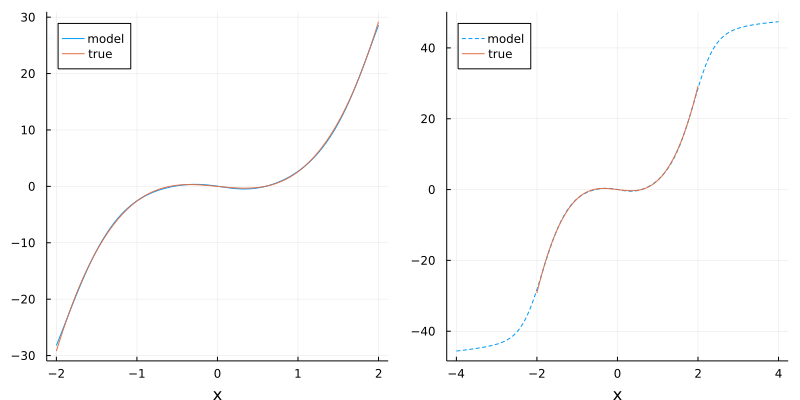

In [558]:
plt1 = plot(x, x->Fneural([x])[1], legend=:topleft, lab="model", xlabel="x")
plot!(x, y, lab="true")

plt2 = plot(range(-4,4,length=200), x->Fneural([x])[1], legend=:topleft, lab="model", xlabel="x", ls=:dash)
plot!(x, y, lab="true")

plot(plt1, plt2, size=(800,400))

Evidently the model is capable to approximate the true function very well. At least on the interval on which it was trained. Extending the domain shows strong deviations from the asymptotic $x^3$ form.

Next we aim to train the model not on the force itself but on the solution of the differential equation.

For backpropagation to work through the ODE solver, we need to separate out the parameters of the model.

In [559]:
# separates the parameters pnn from the architecture fnn
# model can be restored by calling fnn(pnn)
pnn, fnn = Flux.destructure(Fneural)

(Float32[-1.1700995, -2.315487, 0.16037336, -0.42101195, -0.29268116, 0.21136737, 2.1636207, -1.3859403, 2.3003259, -1.8070441  …  -3.627793, -0.97248846, -5.9848537, 1.0470132, -6.9731503, -6.4583983, -1.565806, -7.2494793, -1.232655, 0.2525564], Flux.var"#63#65"{Chain{Tuple{Dense{typeof(tanh), Matrix{Float32}, Vector{Float32}}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}}}(Chain(Dense(1, 16, tanh), Dense(16, 1))))

In [560]:
# generic right hand side of the ODE
# we are going to pass the model parameters as parameters of the ODE
function dudt!(du, u, param, t)
    x,p = u
    du[1] = p
    F = fnn(param)([x])[1]
    du[2] = F
end

dudt! (generic function with 1 method)

In [561]:
#sample the true solution
ts = range(0,10, length=100)
u = anharm_sol.(ts)
ys = getindex.(u, 1);
ps = getindex.(u, 2);

tspan = anharm_prob.tspan

(0.0, 10.0)

In [562]:
# in principle we could optimize over the initial conditions too, but we use the 
# true values here.
prob = ODEProblem(dudt!, [x0, p0], tspan, pnn)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 0.9
 0.0

In [563]:
function predict_osc(;tfinal=length(ts))
    pr = remake(prob, tspan=(0.0, ts[tfinal]))
    OrdinaryDiffEq.solve(pr, Tsit5(), saveat=ts[1:tfinal], sensealg=BacksolveAdjoint())
end

function loss_osc(;tfinal=length(ts))
    sol = predict_osc(;tfinal)
    yhat = getindex.(sol.u, 1)
    phat = getindex.(sol.u, 2)
    sum(abs2, yhat .- ys[1:tfinal]) + sum(abs2, phat .- ps[1:tfinal]), sol
end

loss_osc (generic function with 2 methods)

In [564]:
predict_osc(tfinal=10)

retcode: Success
Interpolation: 1st order linear
t: 10-element Vector{Float64}:
 0.0
 0.10101010101010101
 0.20202020202020202
 0.30303030303030304
 0.40404040404040403
 0.5050505050505051
 0.6060606060606061
 0.7070707070707071
 0.8080808080808081
 0.9090909090909091
u: 10-element Vector{Vector{Float64}}:
 [0.9, 0.0]
 [0.9089570139075922, 0.1785905105221851]
 [0.936596152830898, 0.3726494936754698]
 [0.9853862466368802, 0.6010244958153781]
 [1.0600673527769031, 0.8909247849744834]
 [1.1689644399782435, 1.287860688440321]
 [1.326607201499514, 1.8778093070847948]
 [1.561044830633039, 2.8580182304889754]
 [1.933056163019549, 4.7265080009042935]
 [2.57518566882326, 8.279805025941469]

In [565]:
loss_osc(tfinal=10)[1]

142.16121102125732

In [465]:
Flux.gradient(loss_osc, Flux.params(pnn))

Grads(...)

Initially the true solution and the prediction do not align at all.

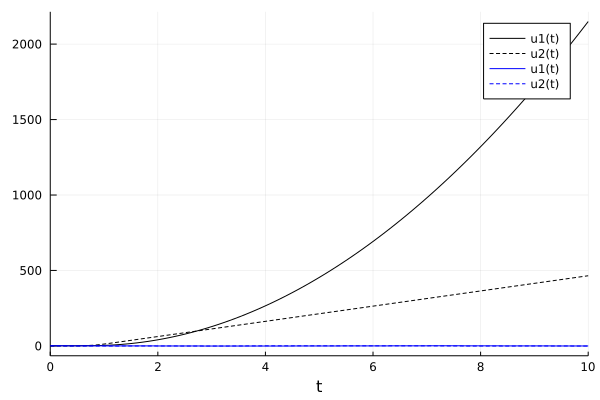

In [566]:
plot(predict_osc(), c=:black, ls=[:solid :dash])
plot!(anharm_sol, c=:blue, ls=[:solid :dash])

Define a callback function that plots the loss and current prediction.

In [121]:
import IJulia

In [567]:
function train_cb_neural(;doplot=false, abstol=1e-5, kwargs...)
    #println("Parameter", p)
    l, sol = loss_osc(;kwargs...)
    println("Loss: ", l)
    if doplot
        plt = plot(sol)
        plot!(anharm_sol)
        display(plt)
    end
    IJulia.clear_output(true) # clears the cell for new plot.
    if l < abstol
        Flux.Optimise.stop()
    end
end

train_cb_neural (generic function with 2 methods)

In [568]:
import Base.Iterators: repeated

In [592]:
# we retain the parameters of the network before elongating the time series
pnns = []

Any[]

In [604]:
# defining a named function instead of using the 
# anonymous version ()->loss_osc()[1]
# decreases the time to compute the gradient by ~1/3
loss_osc_loss_only(kwargs...) = loss_osc(kwargs...)[1]

loss_osc_loss_only (generic function with 1 method)

In [569]:
opt = RADAM(0.001)

RADAM(0.005, (0.9, 0.999), IdDict{Any, Any}())

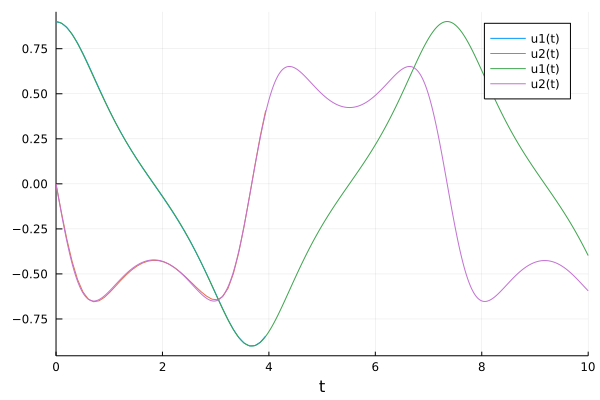

Loss: 0.0021722743316194212


In [589]:
_pnn = Flux.params(pnn)
for tfinal in 10*(1:4)
    Flux.Optimise.train!(loss_osc_loss_only(;tfinal), _pnn,
        repeated( (), 5000),
        opt,
        cb=Flux.throttle(()->train_cb_neural(;doplot=true, abstol=1e-4, tfinal), 2)
    )
    push!(pnns, copy(pnn))
end

In [ ]:
plot(range(-2, 2, length=50), predy)
plot!(range(-2, 2, length=50), x->Flux.gradient(x->V(x, pdefault), x)[1])

#### Representing the potential with a basis layer

`DiffEqFlux.jl` defines learnable layers in terms of function bases. That is, they represent linear combinations of for example sine, cosine, Legendre polynomials, monomials, etc.

In [638]:
# 10th order Legendre polynomial expansion; one output (momentum)
# Note: knowing the potential is polynomial, a better - and more easily interpretable - representation would be 
# choosing monomials as basis.
legendre_layer = TensorLayer([LegendreBasis(10)], 1)

## coefficients
# legendre_layer.p
# 10-element Vector{Float64}:
#  -1.7091073646894235
#   0.37192446910920385
#   0.18824108384059554
#   0.11373444390675648
#   0.026154469864087936
#  -0.288531629599591
#  -0.5439341483262697
#  -0.5869279066707345
#   0.5400504273636575
#  -0.5595880821195836

# generic right hand side of the ODE
# we are going to pass the model parameters as parameters of the ODE
function dudt_legendre!(du, u, param, t)
    x,p = u
    du[1] = p
    F = legendre_layer(x, param)[1]
    du[2] = F
end

prob_legendre = ODEProblem(dudt_legendre!, [x0,p0], tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 0.9
 0.0

In [685]:
## parameter-explicit versions of predict and loss

function predict_legendre(p;tfinal=length(ts))
    pr = remake(prob_legendre, p=p, tspan=(0.0, ts[tfinal]))
    OrdinaryDiffEq.solve(pr, Tsit5(), saveat=ts[1:tfinal], sensealg=ForwardDiffSensitivity())
end

function loss_legendre(p;tfinal=length(ts))
    sol = predict_legendre(p;tfinal)
    yhat = getindex.(sol.u, 1)
    phat = getindex.(sol.u, 2)
    sum(abs2, yhat .- ys[1:tfinal]) + sum(abs2, phat .- ps[1:tfinal]), sol
end

# `sciml_train` passes the (parameters
function train_cb_legendre(p, l, sol)
    global iter
    if iter%50 == 0
        @show l
    end
    iter += 1
    false
end

train_cb_legendre (generic function with 1 method)

Pretrain with ADAM

In [693]:
global iter = 0
leg_opt = DiffEqFlux.sciml_train(loss_legendre, leg_opt.u, ADAM(0.005), maxiters=5000, cb=train_cb_legendre)

l = 0.003014931956751416
l = 0.0020435611017388614
l = 0.002278795446450126
l = 0.0023001431519095736
l = 0.00230377811351663
l = 0.0023077350300507913
l = 0.0023121735682448317
l = 0.00231760613576796
l = 0.002323924996109025
l = 0.0023306773959901267
l = 0.00233774825215466
l = 0.002344790328380239
l = 0.0023513691895733447
l = 0.0023570779405352967
l = 0.0023614368627307685
l = 0.002363886661384773
l = 0.0023640697987214188
l = 0.002361439549456629
l = 0.0023556141889331545
l = 0.0023464580101622856
l = 0.0023338245846074193
l = 0.002317802536623284
l = 0.0022986304225368587
l = 0.0022766708164763173
l = 0.002252367099701485
l = 0.0022262597797133737
l = 0.0021988509345043303
l = 0.0021707202956187323
l = 0.0021422830446552964
l = 0.002113971624680951
l = 0.00208607527907879
l = 0.0020588257152183323
l = 0.002032381298513622
l = 0.002006835015703277
l = 0.0036721261303951126
l = 0.00460985923328996
l = 0.004764017516590176
l = 0.0018689681534233447
l = 0.0019070986221922368
l = 0.00

u: 10-element Vector{Float64}:
 -0.017375979140441058
 -0.817189153188006
 -0.0802064360530564
 -1.2359938124045684
 -0.11433428479219845
  0.42797306197878493
 -0.12262936319455138
  0.4025873858052872
 -0.08920758342533525
  0.24873711324105308

Refine solution

In [696]:
global iter = 0
leg_opt = DiffEqFlux.sciml_train(loss_legendre, leg_opt.u, NewtonTrustRegion(), maxiters=5000, cb=train_cb_legendre)

l = 0.012055485792243803
l = 0.0018629144728257731
l = 0.001862946867575061
l = 0.0018629468675738009
l = 0.0018629468675783632
l = 0.0018629441460354741
l = 0.0018629144728264072
l = 0.0018629468675771714
l = 0.0018629749200523198
l = 0.0018629749200556086
l = 0.00186297729183523
l = 0.001862977291837426
l = 0.0018629967435202087
l = 0.0018629967435217923
l = 0.0018629441460462164
l = 0.0018629772918427939
l = 0.0018628904083832758
l = 0.0018629772918374048
l = 0.001862974920062758
l = 0.0018629749200659862
l = 0.00186297492006001
l = 0.0018629441460554731
l = 0.0018629772918377664
l = 0.001862996743531142
l = 0.0018629468675901324
l = 0.0018629144728401607
l = 0.0018628904083929738
l = 0.001862944146052988
l = 0.0018629144728424221
l = 0.0018629967435262926
l = 0.001862946867587137
l = 0.0018629749200633678
l = 0.001862946867599036
l = 0.0018629749200674852
l = 0.0018629772918539655
l = 0.0018629772918536116
l = 0.0018629749200703384
l = 0.0018629967435270676
l = 0.001862977291849158

u: 10-element Vector{Float64}:
 -0.017417439639717806
 -0.8179980238236488
 -0.07989293975284437
 -1.2363541662527482
 -0.11411797262025854
  0.4278767434173866
 -0.12254730361842156
  0.4025059918487513
 -0.08920592812514752
  0.2487261999083811

Better fit with lot less parameters than the neural net.

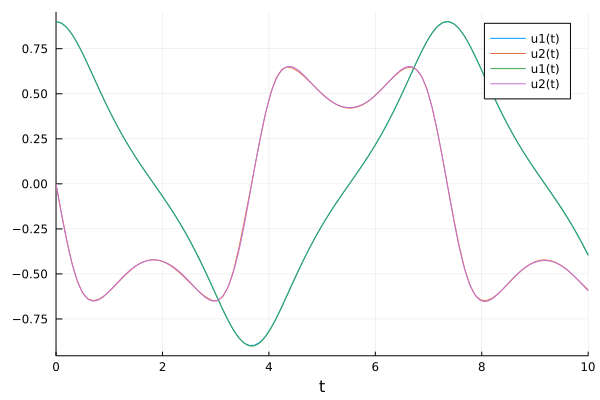

In [701]:
plot(predict_legendre(leg_opt.u))
plot!(anharm_sol)

## A stochastic SDE

-- Under construction --

In [26]:
using StochasticDiffEq

Harmonic oscillator with multiplicative noise.

$
\begin{align}
    dX_t &= V_tdt  \\
    dV_t &= -kX_tdt + \sigma X_t dW_t
\end{align}
$

Bla

In [27]:
function hooke!(du, u, p, t)
    k = p[1]
    x = u[1]
    v = u[2]
    du[1] = v
    du[2] = -k*x
end

function mult_noise!(du, u, p, t)
    σ = p[2]
    du[1] = zero(p[2])
    du[2] = σ*u[1]
end

tspan = (0f0, 10f0)
u0 = [1f0, 0f0]

osc_prob = SDEProblem{true}(hooke!, mult_noise!, u0, tspan)

SDEProblem with uType Vector{Float32} and tType Float32. In-place: true
timespan: (0.0f0, 10.0f0)
u0: 2-element Vector{Float32}:
 1.0
 0.0

Solving the SDEProblem yields a single realization of the stochastic process.

In [ ]:
sol = solve(osc_prob, SOSRI(), p=[2f0,1f0]);

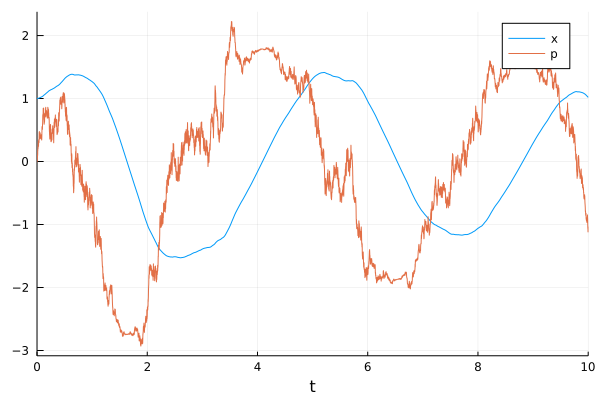

In [30]:
Plots.plot(sol, seriestype=[:line :line], lab=["x" "p"])

To conveniently simulate many trajectories at once (DiffEq has built-in support for computing them parallely), we have to wrap the original problem in an EnsembleProblem to conduct a Monte-Carlo-study.

In [31]:
osc_ens_prob = EnsembleProblem(osc_prob)

EnsembleProblem with problem SDEProblem

We can solve this for example 10k times.

In [32]:
@time ens_sol = StochasticDiffEq.solve(osc_ens_prob, SOSRI(),
    p=[2f0,1f0],
    trajectories=10_000,
    saveat=range(tspan..., length=250));

 62.250187 seconds (229.75 M allocations: 27.903 GiB, 10.95% gc time, 6.49% compilation time)


We are going to train the model on the timeseries of mean and variance.

In [33]:
import StatsBase: mean, var

In [34]:
truem = mean(ens_sol, dims=3)[:,:,1]
truev = var(ens_sol, dims=3)[:,:,1];

In [35]:
truem

2×250 Matrix{Float32}:
 1.0   0.998379    0.99341    0.985226  …   0.0856505   0.0289019  -0.0278502
 0.0  -0.0818001  -0.163865  -0.242964     -1.41219    -1.41812    -1.41019

In [36]:
gr()
default(fmt=:png)

`EnsembleSummary` calculates the mean and the 95% quantiles from an ensemble solution.

In [37]:
summary = EnsembleSummary(ens_sol)

EnsembleSolution Solution of length 250 with uType:
Float32

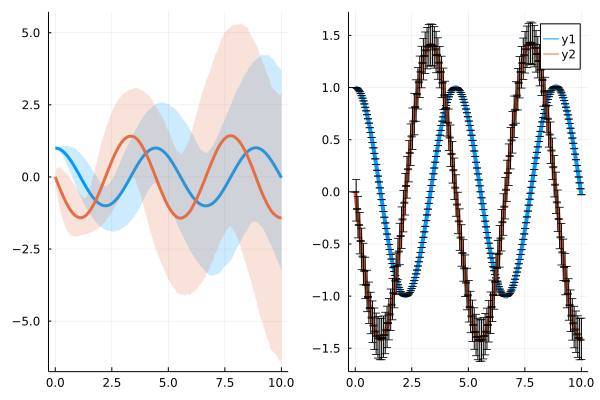

In [38]:
plot(
Plots.plot(summary),
plot(summary.t, truem', yerror=sqrt.(truev), lw=4)
    )

In [39]:
function osc_predict(p; n=100)
    prob = remake(osc_prob, u0=p[1:2], p=p[3:end])
    ens_prob = EnsembleProblem(prob)
    StochasticDiffEq.solve(ens_prob, RKMil(), dt=0.05, trajectories=n, saveat=range(tspan..., length=250), sensealg=ForwardDiffSensitivity())
end

osc_predict (generic function with 1 method)

In [47]:
# Returns both loss and solution. Latter will be fed into training callback.
function osc_loss(p; kwargs...)
    sol = osc_predict(p; kwargs...)
    m = mean(sol, dims=3)[:,:,1]
    v = var(sol, dims=3)[:,:,1]
    sum(abs2, truem .- m) + sum(abs2, truev .- v), sol
end

osc_loss (generic function with 1 method)

In [43]:
p=[u0; [0.1f0,0.11f0]]
remake(osc_prob, u0=p[1:2], p=p[3:end])

SDEProblem with uType Vector{Float32} and tType Float32. In-place: true
timespan: (0.0f0, 10.0f0)
u0: 2-element Vector{Float32}:
 1.0
 0.0

In [46]:
osc_loss(p, n=100)

(7260.717f0,  t: Float32[0.0, 0.04016064, 0.08032128, 0.12048193, 0.16064256, 0.20080322, 0.24096386, 0.2811245, 0.32128513, 0.36144578  …  9.638555, 9.678715, 9.718876, 9.759036, 9.799197, 9.839357, 9.8795185, 9.919679, 9.95984, 10.0]
u: Vector{Float32}[[1.0, 0.0], [1.0, 0.012674728], [1.0004785, -0.006053511], [1.000381, -0.02672188], [0.9994938, -0.037344627], [0.9979655, -0.029800568], [0.99668175, -0.022879297], [0.9956336, -0.016557746], [0.9949143, -0.01567372], [0.9943187, -0.016835788]  …  [-1.5306431, -0.15982144], [-1.5401542, -0.14392039], [-1.5496657, -0.12801899], [-1.5591769, -0.11211795], [-1.5686883, -0.09621654], [-1.5781995, -0.0803155], [-1.5877109, -0.064414084], [-1.5972221, -0.048513055], [-1.6067334, -0.032611627], [-1.6162447, -0.016710598]]
 t: Float32[0.0, 0.04016064, 0.08032128, 0.12048193, 0.16064256, 0.20080322, 0.24096386, 0.2811245, 0.32128513, 0.36144578  …  9.638555, 9.678715, 9.718876, 9.759036, 9.799197, 9.839357, 9.8795185, 9.919679, 9.95984, 10.0]


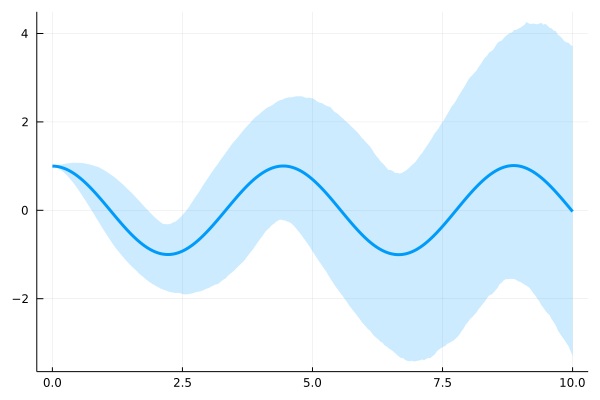

In [60]:
plot(summary, idxs=1)

In [64]:
?IJulia.clear_output

```
clear_output(wait=false)
```

Call `clear_output()` to clear visible output from the current notebook cell.  Using `wait=true` clears the output only when new output is available, which reduces flickering and is useful for simple animations.


In [65]:
function sde_cb(p,l,sol)
    global iter
    if iter%10==0
        IJulia.clear_output(true)
        plot(EnsembleSummary(sol), lab="loss=$l", leg=true, linestyle=:dash, idxs=1)
        plot!(summary, idxs=1)
        ylims!(-6,6) |> display
    end
    iter += 1
    false
end

sde_cb (generic function with 1 method)

In [483]:
p

LoadError: UndefVarError: p not defined

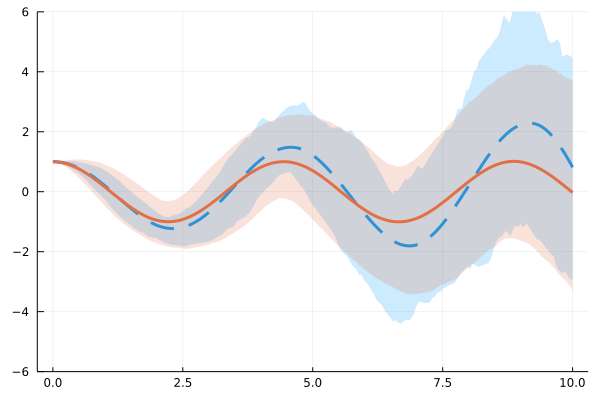

u: 4-element Vector{Float32}:
 1.0
 0.0
 1.9774579
 0.6822521

In [66]:
iter = 0
sde_opt = DiffEqFlux.sciml_train(p->osc_loss(p, n=100), p, Flux.ADAM(0.05), maxiters=1000, cb=sde_cb)

Already quite close to the true parameters (2.0, 1.0). 
Refine with more trajectories. To obtain a good fit, one needs to experiment with the learning rate.

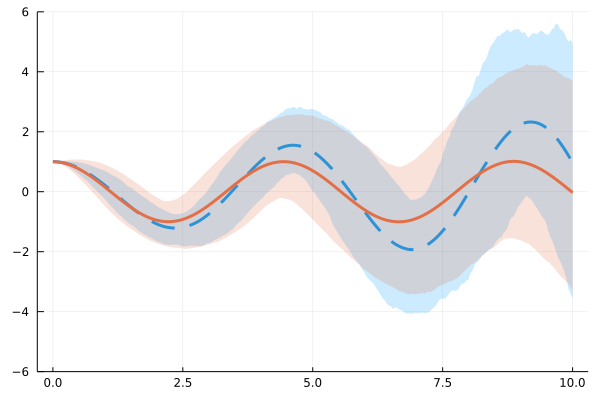

LoadError: InterruptException:

In [67]:
sde_opt = DiffEqFlux.sciml_train(p->osc_loss(p, n=500), sde_opt, sde_opt.alg, maxiters=1000, cb=sde_cb)

## Reaction Networks

`Catalyst` allows building (chemical) reaction networks symbolically. These can be turned then into a deterministic system of ODEs, a system of SDEs, or jump processes (à la Gillespie)

In [1]:
using Catalyst

In [2]:
using DifferentialEquations

Define a simple SIR-type model. Reactions are by default interpreted according to a mass-action law, i.e $[S+I\rightarrow E] = \alpha SI$

States are Susceptible, Infected, Exposed, Hospitalized, Recovered and Deceased.

In [112]:
rn = @reaction_network begin
    β, S + I --> E + I
    α₀, S --> E
    α₁, E --> I + T
    (r,h), I --> (R,H)
    (δ,ϵ), H --> (D,R)
    ν, S --> 0
end β α₀ α₁ r h δ ϵ ν

Model ##ReactionSystem#313 with 8 equations
States (7):
  S(t)
  I(t)
  E(t)
  T(t)
  R(t)
  H(t)
⋮
Parameters (8):
  β
  α₀
  α₁
  r
  h
  δ
⋮

In [370]:
parameters(rn)

7-element Vector{Sym{Real, Base.ImmutableDict{DataType, Any}}}:
 β
 α₀
 α₁
 r
 h
 δ
 ϵ

If `GraphViz` is installed and callable from the command line:

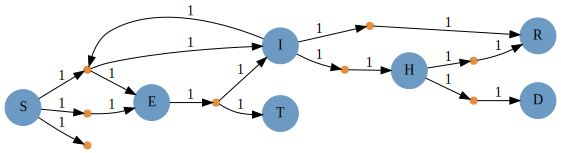

In [170]:
Graph(rn)

`DiscreteProblem` implies that there is no differential equation to be solved, while `JumpProblem` implies a stochastic problem with jumps according to a Poisson process.

`Direct()` refers to the way the rates of the possible jumps are aggrated and corresponds to the Gillespie method, while `SSAStepper()` (Stochastic Simulation Algorithm) advances the solution according to Gillespies original algorithm.

See https://diffeq.sciml.ai/stable/types/jump_types/#Defining-a-Jump-Problem

In [245]:
N = 80*10^4
I0 = 100
R0 = 2.5
α₀ = 0*1e-4/365 # rate of spontenous infection, i.e. by travelling
α₁ = 1/5 # rate of becoming infectious if exposed
h = 0.25/7 # hospitalization rate: 25% within a week of active infection
r = 1/7 - h # recovery rate without hospitalization
γ = h + r # (P(hospitalized|infected) + P(recover|infected ∧ !hospitalized))/day = rate of removal from the infectious population
β = R0*γ/N
δ = (1/7)/21 # P(death|hosp.)/day
ϵ = 1.0/21 - δ # P(recovery|hosp)/day
u0 = [N-I0, 0, I0, 0, 0, 0, 0]
psir = [β, α₀, α₁, 1/7-h, h, δ, ϵ, 0.0] #last parameter: vaccination rate is zero in the beginning

dprob = DiscreteProblem(rn, u0, (0.0, 12*31.0), psir)
jprob = JumpProblem(rn, dprob, Direct(), save_positions=(false,false))


Number of constant rate jumps: 0
Number of variable rate jumps: 0
Have a mass action jump


In [484]:
eprob = EnsembleProblem(jprob)
esol  = solve(eprob, SSAStepper(), trajectories=10, saveat=1)

EnsembleSolution Solution of length 10 with uType:
ODESolution{Int64, 2, Vector{Vector{Int64}}, Nothing, Nothing, Vector{Float64}, Nothing, DiscreteProblem{Vector{Int64}, Tuple{Float64, Float64}, true, Vector{Float64}, DiscreteFunction{true, DiscreteFunction{true, SciMLBase.var"#158#159", Nothing, Nothing}, Nothing, Vector{Symbol}}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, SSAStepper, SciMLBase.ConstantInterpolation{Vector{Float64}, Vector{Vector{Int64}}}, DiffEqBase.DEStats}

In [122]:
string.(species(rn))

7-element Vector{String}:
 "S(t)"
 "I(t)"
 "E(t)"
 "T(t)"
 "R(t)"
 "H(t)"
 "D(t)"

In [5]:
using Plots

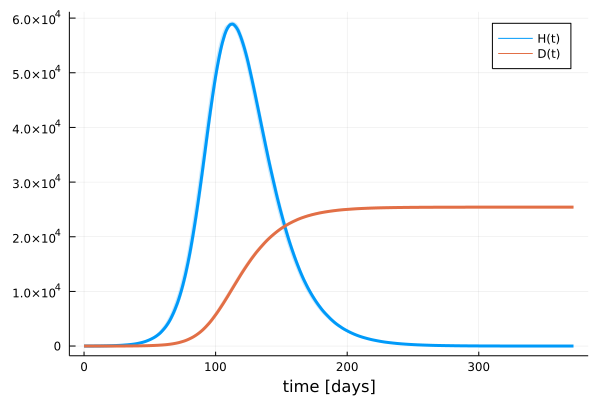

In [486]:
idxs = [6,7]
plot(EnsembleSummary(esol), idxs=idxs, lab=reshape(string.(species(rn))[idxs], 1, :), leg=true, xlabel="time [days]",
    yscale=:identity)
    #ylims=(1e0,80e6))

__Mortality__

In [488]:
using DifferentialEquations.EnsembleAnalysis

In [489]:
print("Mortality: ", timepoint_mean(esol, 300.0)[end] / N)

Mortality: 0.031761

__Intervene when incidence becomes large__

In [480]:
(β₀, β₁) = (β, β/2)

function dointervention_high(u,t,integrator)
    if !isinteger(t)
        return false
    end
    incidence = t>=8.0 ? (u[4] - integrator.sol(t-7)[4]) / (N/10^5) : 0.0
    if isinteger(t) 
        push!(is, incidence)
        push!(βs, integrator.p[1])
    end

    return incidence > 200.0
end
function dointervention_low(u,t,integrator)
    if !isinteger(t)
        return false
    end
    incidence = t>=8.0 ? (u[4] - integrator.sol(t-7)[4]) / (N/10^5) : 0.0
    return incidence < 35.0
end

function vaccine_available(u,t,integrator)
    t >= 365.0
end

## Changing rates of mass-action jumps is hacky at the moment
## Likely going to be made simpler in the future releases.
function affect_high!(integrator)
    integrator.cb.affect!.ma_jumps.scaled_rates[1] = β₁/2
    reset_aggregated_jumps!(integrator)
end
function affect_low!(integrator)
    integrator.cb.affect!.ma_jumps.scaled_rates[1] = β₀/2
    reset_aggregated_jumps!(integrator)
end

function set_vac_rate!(integrator)
    integrator.cb.affect!.ma_jumps.scaled_rates[end] = 0.2/31
    reset_aggregated_jumps!(integrator)
end


intervention_high_cb = DiscreteCallback(dointervention_high, affect_high!, save_positions=(false,false))
intervention_low_cb = DiscreteCallback(dointervention_low, affect_low!, save_positions=(false,false))
vaccine_cb = DiscreteCallback(vaccine_available, set_vac_rate!, save_positions=(false,false))


intervention_cb = CallbackSet(intervention_high_cb, intervention_low_cb, vaccine_cb)        

CallbackSet{Tuple{}, Tuple{DiscreteCallback{typeof(dointervention_high), typeof(affect_high!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(dointervention_low), typeof(affect_low!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT)}, DiscreteCallback{typeof(vaccine_available), typeof(set_vac_rate!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT)}}}((), (DiscreteCallback{typeof(dointervention_high), typeof(affect_high!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT)}(dointervention_high, affect_high!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, Bool[0, 0]), DiscreteCallback{typeof(dointervention_low), typeof(affect_low!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT)}(dointervention_low, affect_low!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, Bool[0, 0]), DiscreteCallback{typeof(vaccine_ava

In [481]:
is = Float64[]
βs = Float64[]

dprob_int = DiscreteProblem(rn, u0, (0.0, 24*31.0), psir)
jprob_int = JumpProblem(rn, dprob_int, Direct(), save_positions=(false,false))
#_eprob_int = EnsembleProblem(jprob_int, prob_func=(p,i,r)->remake(p, p=psir))
sol = solve(jprob_int, SSAStepper(), tstops=0:1:24*31, callback=intervention_cb, saveat=1);

In [470]:
dprob_no_int = DiscreteProblem(rn, u0, (0.0, 12*31.0), psir)
jprob_no_int = JumpProblem(rn, dprob_no_int, Direct(), save_positions=(false,false))
# _eprob_no_int = EnsembleProblem(jprob_no_int)
sol_no_intervention = solve(jprob_no_int, SSAStepper(), tstops=0:1:24*31, saveat=1);

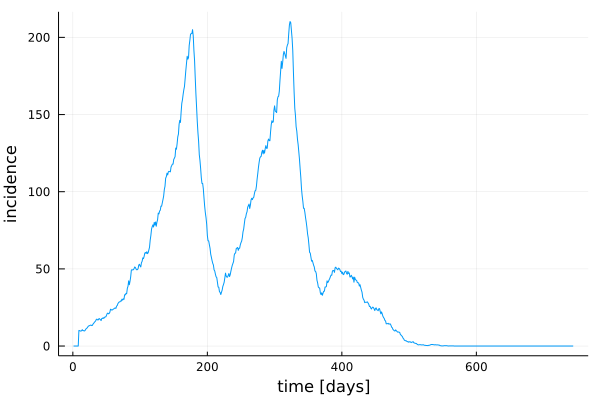

In [482]:
plot(is, ylabel="incidence", xlabel="time [days]", leg=false)

In [494]:
idxs = [6,7]
plot(layout=2,
    plot(sol, vars=idxs, leg=false),
    plot(sol_no_intervention, vars=idxs)
    )